# TDA & Logistic Regression on Heart Arrhythmia DECG Signalling Data

In [244]:
# load in necessary packages
import numpy as np
# import pickle as pck
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gd
# from gudhi.representations.preprocessing import BirthPersistenceTransform
from gudhi.representations import PersistenceImage
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.impute import SimpleImputer
from sklearn.metrics import pairwise_distances
# from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from xgboost import XGBClassifier
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from multiplier import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [256]:
# Define the paths to the files
path_file = "./ECG5000/"
train_file = "ECG5000_TRAIN.tsv"
test_file = "ECG5000_TEST.tsv"
labels_file = "labels.txt"

# Load the training set, test set, and labels file
train_data = pd.read_csv(path_file + train_file, sep="\t", header=None)
test_data = pd.read_csv(path_file + test_file, sep="\t", header=None)

# get rid of the label column and make it its own array
y = train_data.iloc[:, 0].values[:-2]
train_data = train_data.drop(train_data.columns[0], axis = 1)


corr_list = []

train_corr = train_data.corr()
test_corr = test_data.corr()
corr_list.append(train_corr)
corr_list.append(test_corr)

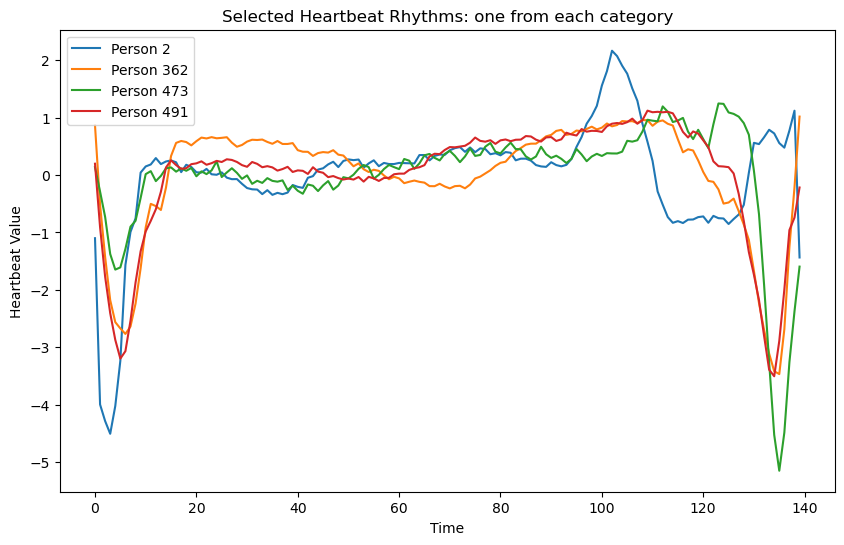

In [18]:
# plot the first few heart rhythms 

# Choosing one person from each group
selected_rows = [1, 361, 472, 490]  

plt.figure(figsize=(10, 6)) 

for index in selected_rows:
    plt.plot(train_data.iloc[index].values, label=f'Person {index+1}')

# Customize the plot
plt.title('Selected Heartbeat Rhythms: one from each category')
plt.xlabel('Time')
plt.legend(loc='best')
plt.ylabel('Heartbeat Value') 
plt.show()

## Classification with TDA
#### Create the persistence diagrams

In [20]:
# Go through each person and make a persistence diagram for each one and add it to a list of all heartbeats 

barcodes_list = []

for index, row in train_data.iterrows():
    data = train_data.iloc[index].values.reshape(-1, 1)
    
    distance_matrix = pairwise_distances(data)
    
    skeleton = gd.RipsComplex(
        distance_matrix=distance_matrix, max_edge_length= 0.8)
    
    Rips_simplex_tree = skeleton.create_simplex_tree(max_dimension=2)

    rips_filtration = Rips_simplex_tree.get_filtration()
    rips_list = list(rips_filtration)


    BarCodes_Rips = Rips_simplex_tree.persistence()


    BarCodes_Rips_0 = Rips_simplex_tree.persistence_intervals_in_dimension(0)
    #BarCodes_Rips_1 = Rips_simplex_tree.persistence_intervals_in_dimension(1)
    
    # only adding in dimension 0 because cycles not present in this data
    barcodes_list.append(BarCodes_Rips_0)

In [21]:
# now we will repeat the above but only for the second half of the data

barcodes_list_mod = []

for index, row in train_data.iterrows():
    
    data = train_data.iloc[index, -60:].values.reshape(-1, 1)
    
    distance_matrix = pairwise_distances(data)
    
    skeleton = gd.RipsComplex(
        distance_matrix=distance_matrix, max_edge_length= 0.8)
    
    Rips_simplex_tree = skeleton.create_simplex_tree(max_dimension=2)

    rips_filtration = Rips_simplex_tree.get_filtration()
    rips_list = list(rips_filtration)


    BarCodes_Rips = Rips_simplex_tree.persistence()
    
    BarCodes_Rips_0 = Rips_simplex_tree.persistence_intervals_in_dimension(0)
    
    barcodes_list_mod.append(BarCodes_Rips_0)

#### Create the persistence images

In [257]:
# now create persistence images for each one 

persistence_img_list = []
persistence_img_list_mod = []

for index, row in train_data.iterrows():
    
    persistence_image = PersistenceImage(bandwidth=0.2, im_range=[0, 1, 0, 1], resolution=[20, 20])
    
    BarCodes_Rips_0 = barcodes_list[index]
    persistence_image_H0 = persistence_image.fit_transform([BarCodes_Rips_0])[0]
    
    persistence_image_mod = PersistenceImage(bandwidth=0.2, im_range=[0, 1, 0, 1] ,resolution=[20, 20])
    BarCodes_Rips_0_mod = barcodes_list_mod[index]
    persistence_image_H0_mod = persistence_image.fit_transform([BarCodes_Rips_0_mod])[0]
    
    persistence_img_list.append(persistence_image_H0)
    persistence_img_list_mod.append(persistence_image_H0_mod)

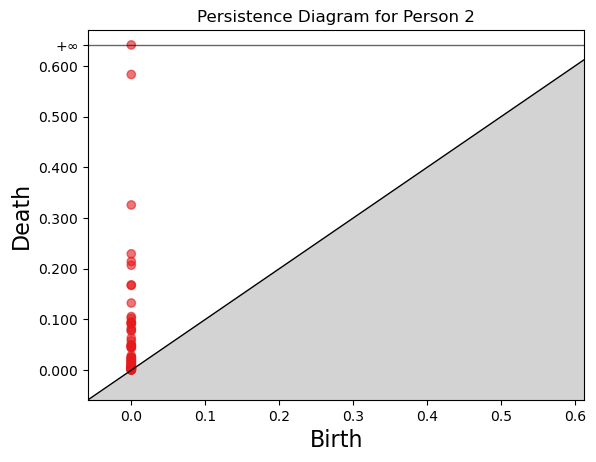

<Figure size 1000x600 with 0 Axes>

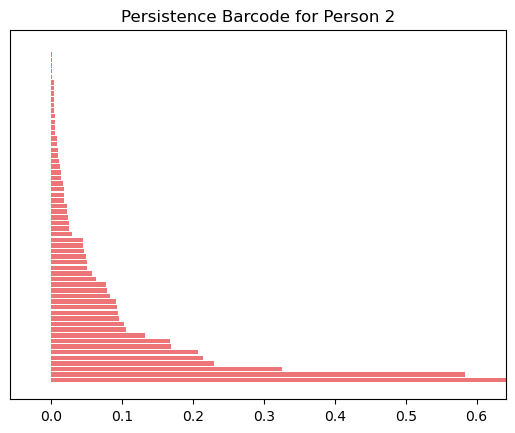

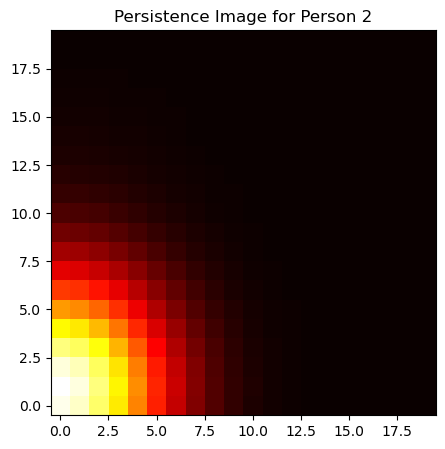

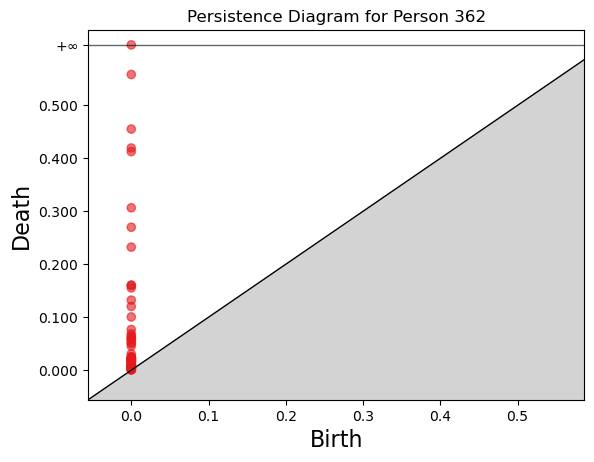

<Figure size 1000x600 with 0 Axes>

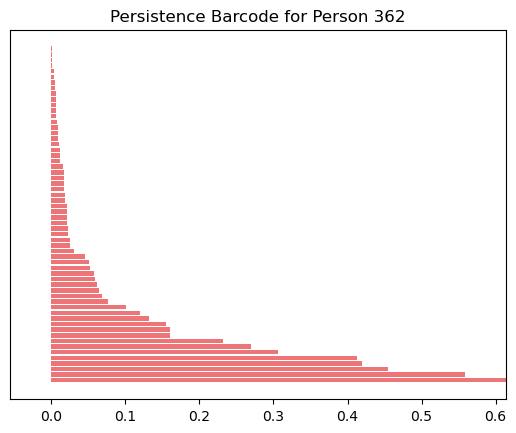

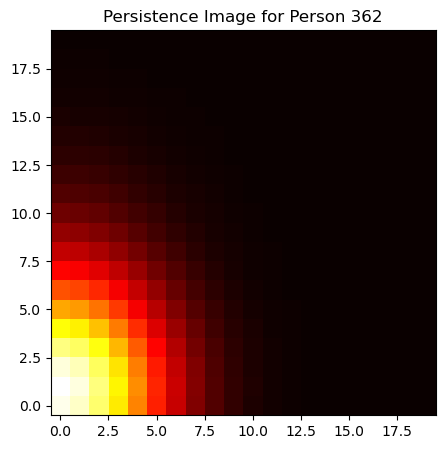

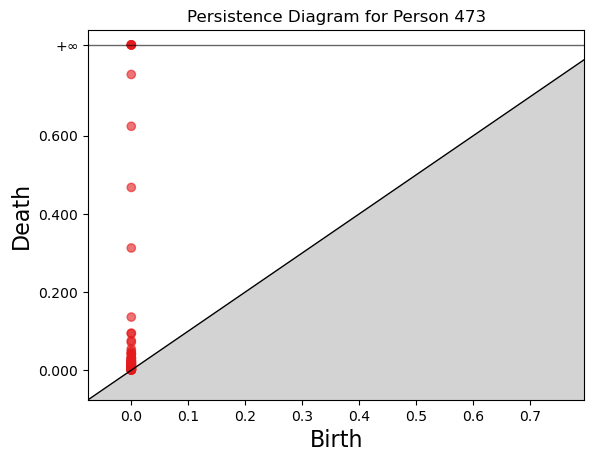

<Figure size 1000x600 with 0 Axes>

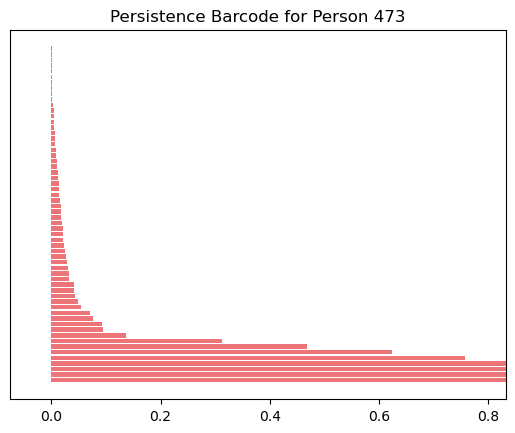

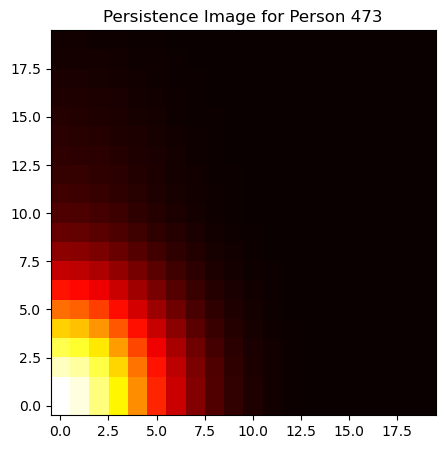

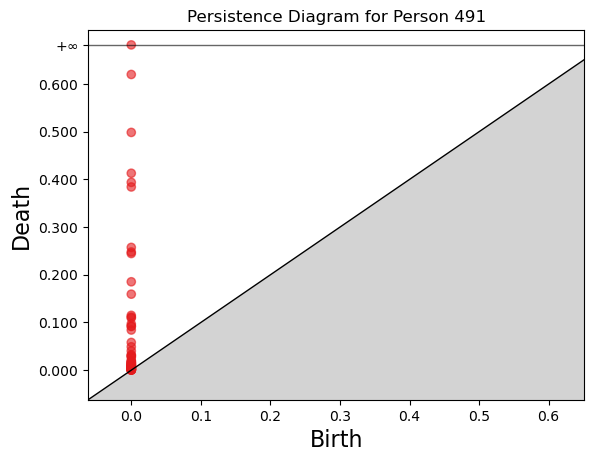

<Figure size 1000x600 with 0 Axes>

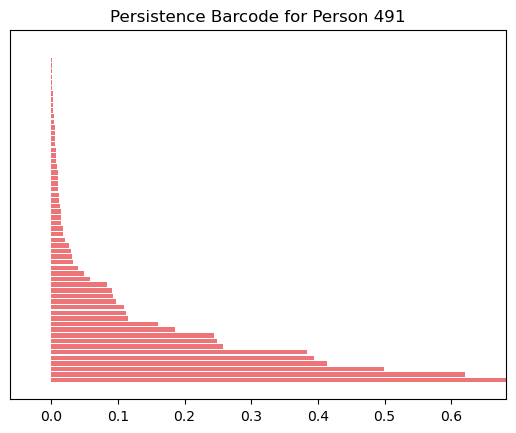

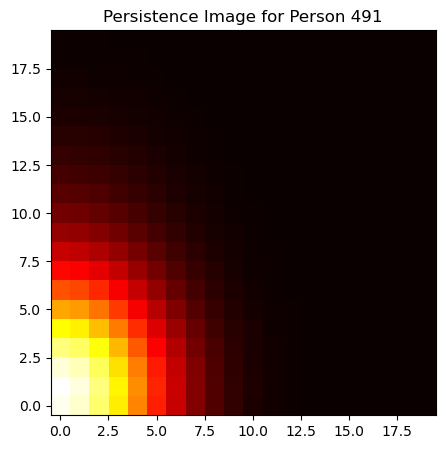

In [258]:
# show plots for randomly selected images from each group 

for index in selected_rows: 
    
    BarCodes_Rips = barcodes_list_mod[index]
    persistence_image_H0 = persistence_img_list_mod[index]
    gd.plot_persistence_diagram(BarCodes_Rips)
    plt.title(f'Persistence Diagram for Person {index+1}')
    
    plt.figure(figsize=(10, 6))
    gd.plot_persistence_barcode(BarCodes_Rips)
    plt.title(f'Persistence Barcode for Person {index+1}')
    plt.show()
    
    resolution = [20, 20]
    persistence_image_H0_mat = persistence_image_H0.reshape(resolution)
    plt.figure(figsize=(5, 5))
    plt.imshow(persistence_image_H0_mat, cmap='hot', origin='lower')
    plt.title(f'Persistence Image for Person {index+1}')
    plt.show()

### Now that we have a vector representation for each PD, we will perform classification:

Logistic Regression:

In [259]:
# we are now going to focus on binary classification using logistic regression of group 1: A-fib and group 2: atrial tachycardia because they are the groups with the most variance in shape 

X_main = [] # will store persistence images for both groups

for i in range(0, 291):
    X_main.append(persistence_img_list[i]) # appends images from A-fib group
for i in range(292,468):
    X_main.append(persistence_img_list[i]) # appends images from tachycardia group
   
y_arr =  np.concatenate([np.zeros(292), np.ones(175)]) # list containing labels for data
X_mat = np.array(X_main) 


# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_mat, y_arr)

# Train the logistic regression model
logReg = LogisticRegression(max_iter=1000)
results = logReg.fit(X_train, y_train)

# Predict the labels for the test set
test_result = logReg.predict(X_test)

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(y_test, test_result)

# Print the accuracy
print(f'Accuracy: {accuracy}')

Accuracy: 0.8974358974358975


Logistic Regression on the modified set:

In [260]:
# now do it with the modified ones and compare the results 

X_main = []

for i in range(0, 291):
    X_main.append(persistence_img_list_mod[i])
for i in range(292,468):
    X_main.append(persistence_img_list_mod[i])
   
y_arr =  np.concatenate([np.zeros(292), np.ones(175)])
X_mat = np.array(X_main)


X_train, X_test, y_train, y_test = train_test_split(X_mat, y_arr)

logReg = LogisticRegression(max_iter=1000)
results = logReg.fit(X_train, y_train)
test_result = logReg.predict(X_test)
accuracy = accuracy_score(y_test, test_result)

print(f'Accuracy: {accuracy}')

Accuracy: 0.9743589743589743


DTC on the modified set:

In [265]:
# Decision Tree Classifier after TDA

dtc = DecisionTreeClassifier()

# Fit model to training data
dtc.fit(X_train, y_train)

# Evaluate training accuracy
pred = dtc.predict(X_test)

training_acc = accuracy_score(y_test, pred)

# Check size of decision tree
num_leaves = dtc.get_n_leaves()

# Report results
print('Trained decision tree with {} leaves and training accuracy {:.2f}.'.format(num_leaves, training_acc))

Trained decision tree with 11 leaves and training accuracy 0.96.


Linear Discriminant Analysis on the modified set:

In [262]:
# Linear Discriminant Analysis

lda = LinearDiscriminantAnalysis().fit(X_train, y_train) # fit model using training data
lda_predictions = lda.predict(X_test) # use model to make predictions on the test set
lda_accuracy = accuracy_score(y_test, lda_predictions)
print(f"LDA Test Accuracy for model with all features: {lda_accuracy}")

LDA Test Accuracy for model with all features: 0.9829059829059829


### Comparisons over all groups using multiclass logistic regression

Now we will see how the model does when comparing all 4 groups. Note that the 5th group is an unlabeled group consisting of only 2 people, so we will not be using it

https://www.kaggle.com/code/satishgunjalmulticlass-logistic-regression-using-sklearn

In [252]:
# get the data
X = np.array(persistence_img_list[:-2])
print(X.shape)
print(y.shape)
X_train,X_test, y_train, y_test = train_test_split(X, y)

(498, 400)
(498,)


0.808


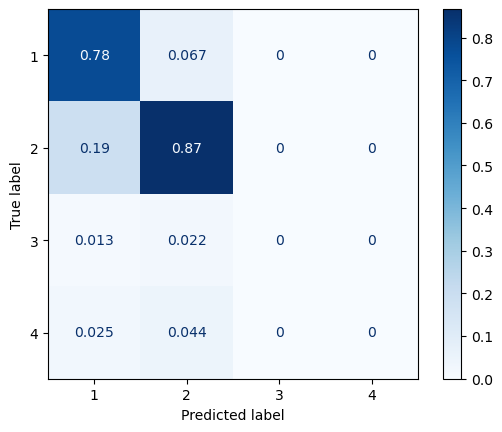

In [253]:
# Train and fit logistic regression model. 
model = LogisticRegression(max_iter=1000, multi_class='ovr') # multi_class parameter specifies "one-vs-rest" strategy for multi-class classification
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))

# generate a confusion matrix to show model performance
matrix = confusion_matrix(y_test, y_pred, normalize="pred")
cm = ConfusionMatrixDisplay(matrix, display_labels=[1,2,3,4])

# Plot the confusion matrix
cm.plot(cmap=plt.cm.Blues)  
plt.show()

Now we will repeat using just the second half of the timeseries data again:

In [266]:
# get the data
X = np.array(persistence_img_list_mod[:-2])
X_train, X_test, y_train, y_test = train_test_split(X, y)

0.896


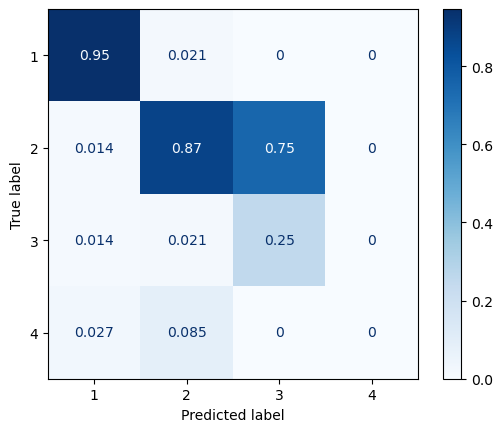

In [268]:
model = LogisticRegression(max_iter=1000, multi_class='ovr')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))

matrix = confusion_matrix(y_test, y_pred, normalize="pred")
cm = ConfusionMatrixDisplay(matrix, display_labels=[1, 2, 3, 4])

# Plot the confusion matrix
cm.plot(cmap=plt.cm.Blues)
plt.show()

## Comparison with non-TDA Classification

Logistic Regression:

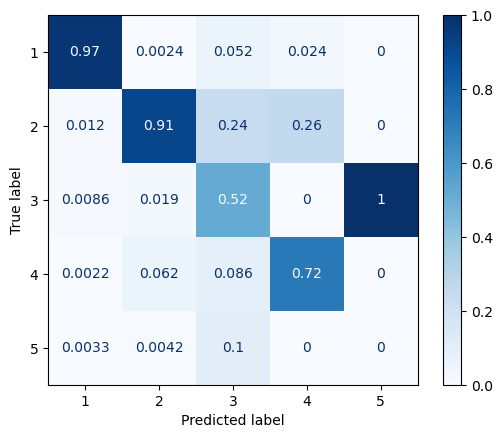

In [237]:
# Logistic Regression

# Load the raw training set and test set
train_data = pd.read_csv(path_file + train_file, sep="\t", header=None)
test_data = pd.read_csv(path_file + test_file, sep="\t", header=None)

# Separate labels and features
y_train = train_data.iloc[:, 0].values
X_train = train_data.drop(train_data.columns[0], axis=1)
y_test = test_data.iloc[:, 0].values
X_test = test_data.drop(test_data.columns[0], axis=1)

# Initialize and train the logistic regression model
model_raw = LogisticRegression(max_iter=1000, multi_class='ovr')
model_raw.fit(X_train, y_train)

# Predict on the test set
y_test_pred = model_raw.predict(X_test)

# Compute and plot the confusion matrix
matrix = confusion_matrix(y_test, y_test_pred, normalize='pred')
cm = ConfusionMatrixDisplay(matrix, display_labels=np.unique(y_test))

cm.plot(cmap=plt.cm.Blues)
plt.show()

DTC:

In [239]:
# Decision Tree Classifier 

dtc = DecisionTreeClassifier()

# Fit model to training data
dtc.fit(X_train, y_train)

# Evaluate training accuracy
pred = dtc.predict(X_test)

training_acc = accuracy_score(y_test, y_test_pred)

# Check size of decision tree
num_leaves = dtc.get_n_leaves()

# Report results
print('Trained decision tree with {} leaves and training accuracy {:.2f}.'.format(num_leaves, training_acc))

0.9404444444444444
25
Trained decision tree with 25 leaves and training accuracy 0.94.


Linear Discriminant Analysis:

In [245]:
# Linear Discriminant Analysis

lda = LinearDiscriminantAnalysis().fit(X_train, y_train) # fit model using training data
lda_predictions = lda.predict(X_test) # use model to make predictions on the test set
lda_accuracy = accuracy_score(y_test, lda_predictions)
print(f"LDA Test Accuracy for model with all features: {lda_accuracy}")

LDA Test Accuracy for model with all features: 0.9266666666666666
